Скачивание dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nibinv23/iam-handwriting-word-database")

print("Path to dataset files:", path)

100%|██████████| 1.10G/1.10G [00:12<00:00, 97.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nibinv23/iam-handwriting-word-database/versions/2


Проверка корректности путей

In [8]:
import kagglehub
import os

# Скачиваем датасет
path = kagglehub.dataset_download("nibinv23/iam-handwriting-word-database")
print("Путь к датасету:", path)

# Проверяем содержимое папки
print("Файлы в датасете:", os.listdir(path))

Путь к датасету: /root/.cache/kagglehub/datasets/nibinv23/iam-handwriting-word-database/versions/2
Файлы в датасете: ['words_new.txt', 'iam_words']


In [7]:
word_dict = {}

with open("/root/.cache/kagglehub/datasets/nibinv23/iam-handwriting-word-database/versions/2/words_new.txt", "r", encoding="utf-8") as file:
    for line in file:
        # Пропускаем строки, начинающиеся с #
        if line.startswith("#"):
            continue

        parts = line.strip().split()

        # Пропускаем строки с ошибками сегментации
        if parts[1] != "ok":
            continue

        # Берём первый элемент как ключ и последний как значение
        word_id = parts[0]
        word = parts[-1]

        word_dict[word_id] = word


In [17]:
# Проверим, что получилось
print(list(word_dict.items())[:100])  # Выведет первые 10 элементов словаря

[('a01-000u-00-00', 'A'), ('a01-000u-00-01', 'MOVE'), ('a01-000u-00-02', 'to'), ('a01-000u-00-03', 'stop'), ('a01-000u-00-04', 'Mr.'), ('a01-000u-00-05', 'Gaitskell'), ('a01-000u-00-06', 'from'), ('a01-000u-01-00', 'nominating'), ('a01-000u-01-01', 'any'), ('a01-000u-01-02', 'more'), ('a01-000u-01-03', 'Labour'), ('a01-000u-01-04', 'life'), ('a01-000u-01-05', 'Peers'), ('a01-000u-02-00', 'is'), ('a01-000u-02-01', 'to'), ('a01-000u-02-02', 'be'), ('a01-000u-02-03', 'made'), ('a01-000u-02-04', 'at'), ('a01-000u-02-05', 'a'), ('a01-000u-02-06', 'meeting'), ('a01-000u-02-07', 'of'), ('a01-000u-02-08', 'Labour'), ('a01-000u-04-00', 'put'), ('a01-000u-04-01', 'down'), ('a01-000u-04-02', 'a'), ('a01-000u-04-03', 'resolution'), ('a01-000u-04-04', 'on'), ('a01-000u-04-05', 'the'), ('a01-000u-04-06', 'subject'), ('a01-000u-06-00', 'Griffiths'), ('a01-000u-06-01', ','), ('a01-000u-06-02', 'P'), ('a01-000u-06-03', 'for'), ('a01-000u-06-04', 'Manchester'), ('a01-000u-06-05', 'Exchange'), ('a01-000u

Все нужные импорты

In [9]:
import math
import random
import os
import numpy as np
import cv2
import string

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import get_value, ctc_decode
from keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

Код для обработки изображений

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def adaptive_threshold(image):
    # Применим фильтр Гаусса
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Применение адаптивной бинаризации
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY, 21, 10)

    # Инверсия цветов
    inverted = cv2.bitwise_not(binary)

    return inverted

def normalize(image):
    normalized = image.astype(np.float32) / 255.0

    return normalized

def resize_and_reshape(image, target_size=(64, 200)):
    # Конвертация в grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Изменение размера
    h, w = gray.shape
    if h > target_size[0] or w > target_size[1]:
        shrink = min(target_size[0]/h, target_size[1]/w)
        resized = cv2.resize(gray, None, fx=shrink, fy=shrink,
                            interpolation=cv2.INTER_AREA)
    else:
        resized = gray.copy()

    # Добавление рамок
    pad_h = target_size[0] - resized.shape[0]
    pad_w = target_size[1] - resized.shape[1]
    padded = cv2.copyMakeBorder(resized,
                               math.ceil(pad_h/2), math.floor(pad_h/2),
                               math.ceil(pad_w/2), math.floor(pad_w/2),
                               cv2.BORDER_CONSTANT, value=255)

    # Поворот
    rotated = cv2.rotate(padded, cv2.ROTATE_90_CLOCKWISE)

    return rotated

def preprocess_image(image):
    resized = resize_and_reshape(image)

    thresholded = adaptive_threshold(resized)

    normalized = normalize(thresholded)

    return normalized

Функции для закодирования и разкодирования

In [11]:
def decode_label(num, alphabet):
    return ''.join(alphabet[ch] for ch in num if ch != len(alphabet))

def decode_predictions(nums):
    input_length = np.ones(nums.shape[0]) * nums.shape[1]
    values = get_value(
        ctc_decode(nums, input_length=input_length, greedy=True)[0][0]
    )

    texts = [decode_label(value[value >= 0], alphabet) for value in values]
    return texts


def encode_labels(texts):
    def _decode_label(label, alphabet):
        return np.array([alphabet.find(ch) for ch in label])

    # Создание алфавита из текстов
    alphabet = ''.join(sorted(set(''.join(texts))))

    max_len = max(len(text) for text in texts)
    nums = np.full((len(texts), max_len), fill_value=len(alphabet), dtype='int64')

    for i, text in enumerate(texts):
        nums[i, :len(text)] = _decode_label(text, alphabet)

    return nums, alphabet

Функция для проверки изображений

In [12]:
def check_random_image(train_X, train_y, num_images=8):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        random_index = random.randint(0, len(train_X) - 1)
        random_image = train_X[random_index]
        random_label = train_y[random_index]

        plt.subplot(2, 4, i + 1)
        plt.imshow(random_image, cmap='gray')
        plt.title(f'Label: {random_label}')
        plt.axis('off')
    plt.show()

Метрика и функция потерь

In [13]:
class CharacterErrorRateCalculator(tf.keras.metrics.Metric):
    def __init__(self, name='character_error_score', **kwargs):
        super(CharacterErrorRateCalculator, self).__init__(name=name, **kwargs)
        self.error_sum = self.add_weight(name="cumulative_errors", initializer="zeros")
        self.num_samples = self.add_weight(name="sample_counter", initializer="zeros")

    def update_state(self, ground_truth, predictions, sample_weight=None):
        pred_shape = K.shape(predictions)
        seq_len = tf.ones(shape=pred_shape[0]) * K.cast(pred_shape[1], 'float32')

        decoded_output, _ = K.ctc_decode(predictions, seq_len, greedy=True)

        sparse_decoded = K.ctc_label_dense_to_sparse(decoded_output[0], K.cast(seq_len, 'int32'))
        sparse_truth = K.ctc_label_dense_to_sparse(ground_truth, K.cast(seq_len, 'int32'))
        sparse_truth = tf.sparse.retain(sparse_truth, tf.not_equal(sparse_truth.values, tf.math.reduce_max(sparse_truth.values)))

        sparse_decoded = tf.sparse.retain(sparse_decoded, tf.not_equal(sparse_decoded.values, -1))
        error_rate = tf.edit_distance(sparse_decoded, sparse_truth, normalize=True)

        self.error_sum.assign_add(tf.reduce_sum(error_rate))
        self.num_samples.assign_add(K.cast(ground_truth.shape[1], 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.error_sum, self.num_samples)

    def reset_state(self):
        self.error_sum.assign(0.0)
        self.num_samples.assign(0.0)

def CTCLoss(targets, outputs):
    batch_size = tf.cast(tf.shape(targets)[0], dtype="int64")
    output_seq_length = tf.cast(tf.shape(outputs)[1], dtype="int64")
    target_seq_length = tf.cast(tf.shape(targets)[1], dtype="int64")

    output_seq_length = output_seq_length * tf.ones(shape=(batch_size, 1), dtype="int64")
    target_seq_length = target_seq_length * tf.ones(shape=(batch_size, 1), dtype="int64")

    calculated_loss = K.ctc_batch_cost(targets, outputs, output_seq_length, target_seq_length)
    return calculated_loss

Архитектура нейронной сети

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
def create_model(num_classes, input_shape=(200, 64, 1)):
    input_img = Input(shape=input_shape, name='image_input')

    # Сверточные слои с нормализацией
    x = Conv2D(64, (5, 5), padding='same')(input_img)
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D((1, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.01)(x)
    x = MaxPooling2D((2, 2))(x)

    # Reshape для LSTM слоев
    x = Reshape((25, -1))(x)

    # Полносвязный слой с Dropout
    x = Dense(256)(x)
    x = LeakyReLU(0.01)(x)
    x = Dropout(0.5)(x)

    # Рекуррентные слои
    x = Bidirectional(LSTM(256, return_sequences=True))(x)
    x = Bidirectional(LSTM(256, return_sequences=True))(x)

    # Полносвязный слой с Dropout
    x = Dense(256)(x)
    x = LeakyReLU(0.01)(x)
    x = Dropout(0.5)(x)

    # Выходной слой
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=x)
    model.compile(optimizer=Nadam(learning_rate=0.001, clipnorm=1.0), loss=CTCLoss, metrics=[CharacterErrorRateCalculator()])

    model.summary()

    return model

Функция для загрузки изображений и метрики

In [20]:
def process_data(word_dict):
    image_base_folder = f'/root/.cache/kagglehub/datasets/nibinv23/iam-handwriting-word-database/versions/2/iam_words/words'
    train_X, train_y = [], []
    total_count = 0
    folder_counts = {}
    max_per_folder = 200
    max_total = 15000

    for root, _, files in os.walk(image_base_folder):
        if total_count >= max_total:
            break

        folder_name = os.path.basename(root)
        folder_counts[folder_name] = 0

        for image_file in files:
            if total_count >= max_total:
                break

            if folder_counts[folder_name] >= max_per_folder:
                break

            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_name = image_file.rsplit('.', 1)[0]

                # Проверяем, есть ли имя в словаре
                if image_name not in word_dict:
                    continue  # Пропускаем изображение без метки

                label = word_dict[image_name]
                if label == 'Ps':
                  continue

                if not any(c not in string.ascii_letters + ',.\' ' for c in label):
                    image_path = os.path.join(root, image_file)
                    if os.path.exists(image_path):
                        try:
                            img_array = cv2.imread(image_path, cv2.IMREAD_COLOR)
                            if img_array is None:
                                raise ValueError("Failed to read image with OpenCV")

                            if len(label) <= 12:
                                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                                train_X.append(preprocess_image(img_array))
                                train_y.append(label)
                                folder_counts[folder_name] += 1
                                total_count += 1
                        except Exception as e:
                            print(f"Failed to load image: {image_path}, error: {e}")
                    else:
                        print(f"File does not exist: {image_path}")

    return np.array(train_X), np.array(train_y)


In [21]:
# Обработка данных для train и test
train_X, train_y = process_data(word_dict)
train_y, alphabet = encode_labels(train_y)

Failed to load image: /root/.cache/kagglehub/datasets/nibinv23/iam-handwriting-word-database/versions/2/iam_words/words/a01/a01-117/a01-117-05-02.png, error: Failed to read image with OpenCV


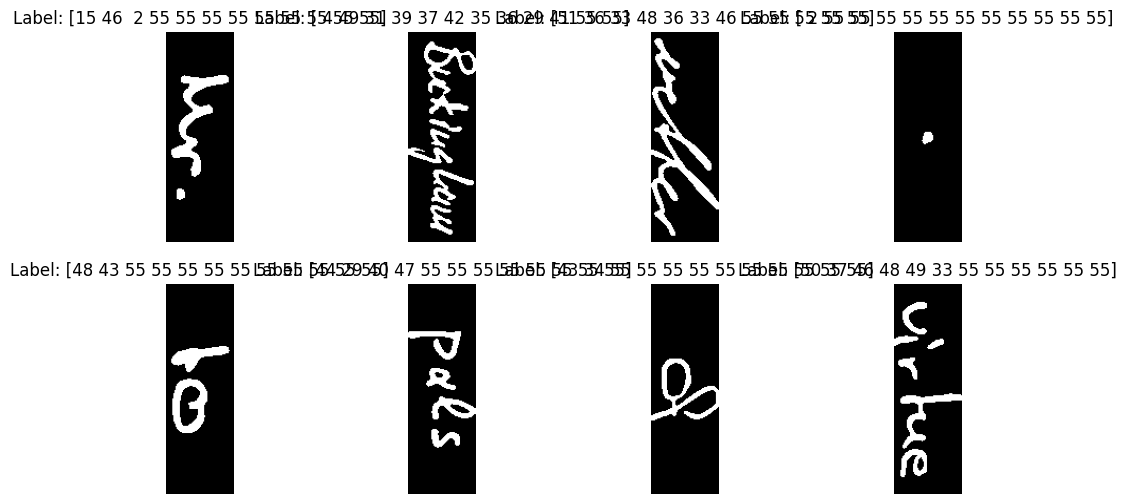

Подготовка данных окончена


In [22]:
# Пример вывода данных
check_random_image(train_X, train_y)
# Разбиваем данные: 80% - train+val, 20% - test
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

# Разбиваем train+val: 80% - train, 20% - val (итого: 64% train, 16% val, 20% test)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

print("Подготовка данных окончена")

Инициализация нейронной сети

In [23]:
num_classes = len(alphabet) + 1  # Количество классов + 1 для CTC blank
print(alphabet)
print(f"Форма y_true: {train_y.shape}")
print(num_classes)
input_shape = (200, 64, 1)
model = create_model(num_classes, input_shape)

',.ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Форма y_true: (9600, 12)
56


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 200, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 200, 64, 64)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 200, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 32, 128)   │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 32, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 100, 32, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 50, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 8, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 8, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 50, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 8, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 8, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 50, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 4, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 256)        │             

 Total params: 4,276,152 (16.31 MB)

 Trainable params: 4,274,616 (16.31 MB)

 Non-trainable params: 1,536 (6.00 KB)

Обучение

In [24]:
# Callbacks (обратные вызовы)
early_stopping = EarlyStopping(monitor='val_character_error_score',
                              patience=10,
                              restore_best_weights=True,
                              mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_character_error_score',
                             factor=0.5,
                             min_lr=1e-5,
                             patience=4,
                             mode='min')
history = model.fit(
  train_X, train_y,
  validation_data=(val_X, val_y),
  epochs=60,
  batch_size=64,
  callbacks=[early_stopping, reduce_lr],
  verbose=1
    )

Epoch 1/60
 45/150 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - character_error_score: 8.4065 - loss: 26.9180

KeyboardInterrupt: 

Сохранение модели

In [ ]:
from google.colab import files
model.save('handwritten.keras')
files.download('handwritten.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Вывод метрики и функции потерь при обучении

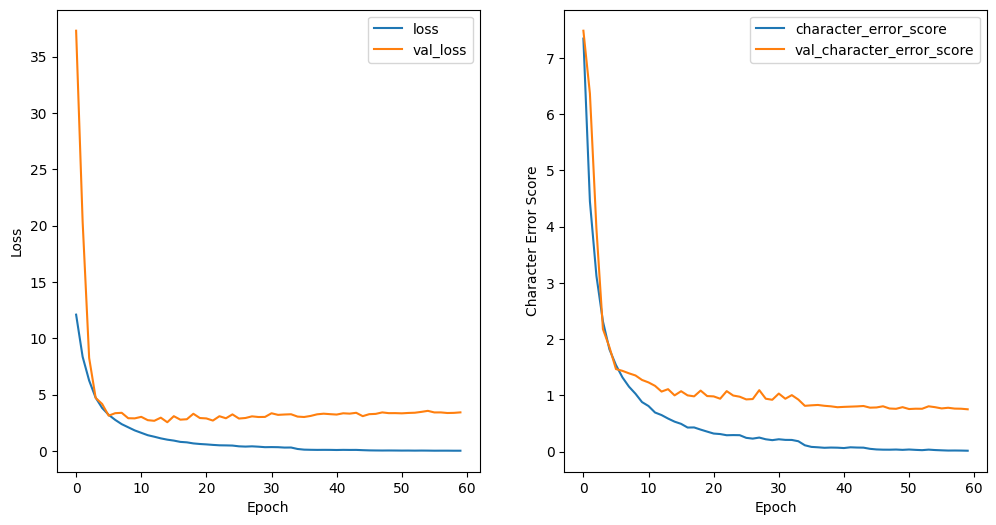

In [ ]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history.history['character_error_score'], label='character_error_score')
axes[1].plot(history.history['val_character_error_score'], label='val_character_error_score')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Character Error Score")
axes[1].legend()

plt.show()

In [25]:
# Оценка модели на тестовом наборе данных
loss, accuracy = model.evaluate(test_X, test_y)

# Вывод значений потерь и точности
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - character_error_score: 2.6665 - loss: 26.2793
Loss: 25.999515533447266
Accuracy: 2.659574508666992


Вывод всех предсказанных символов с соответствующими изображениями

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


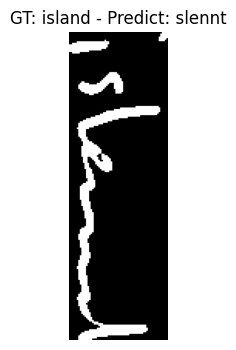

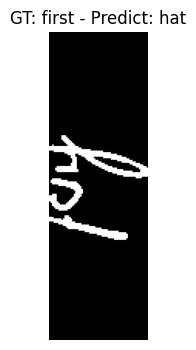

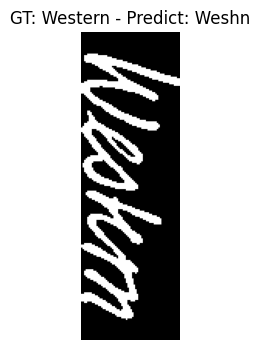

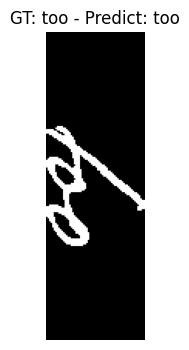

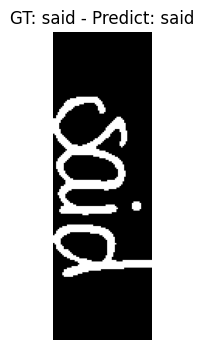

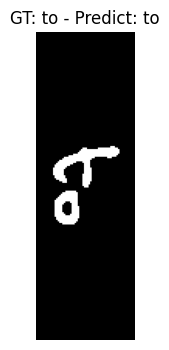

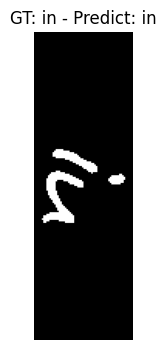

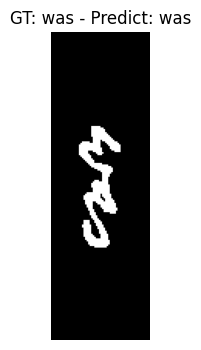

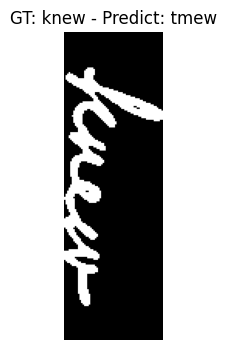

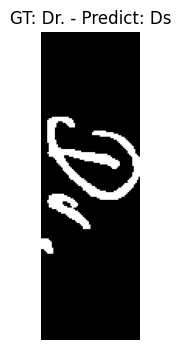

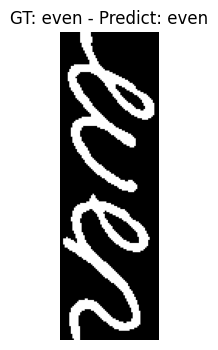

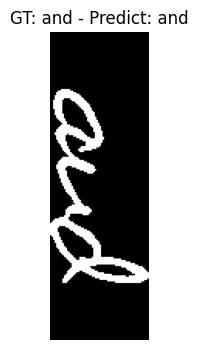

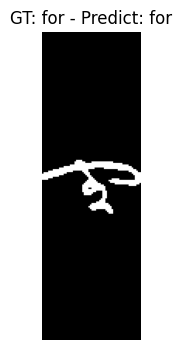

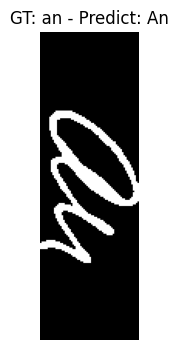

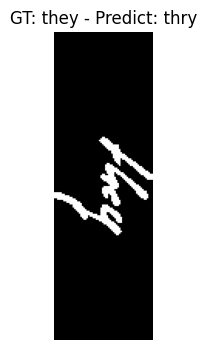

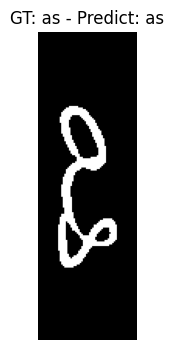

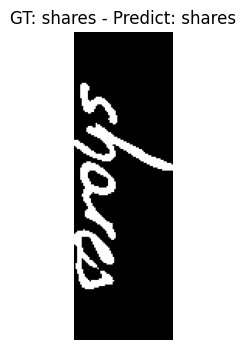

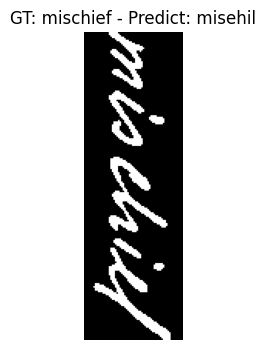

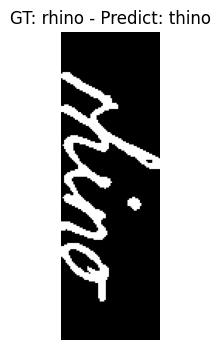

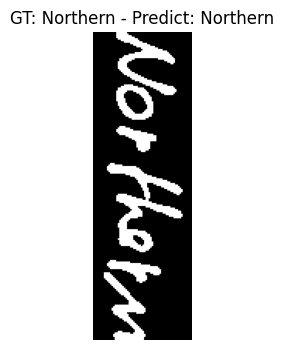

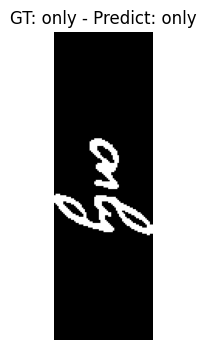

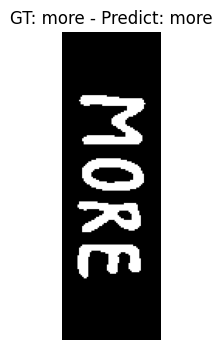

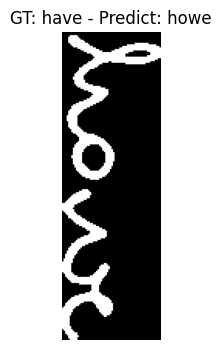

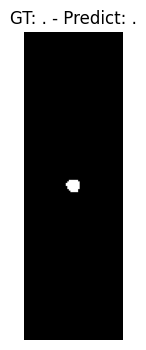

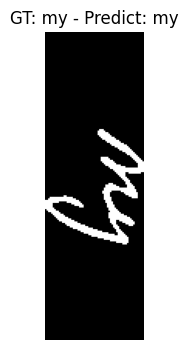

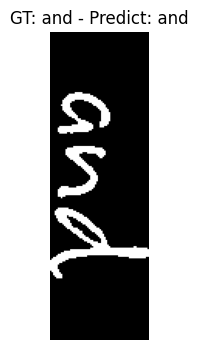

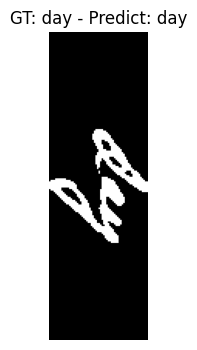

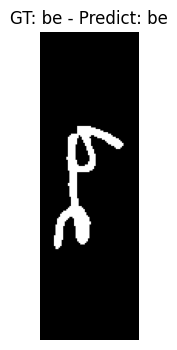

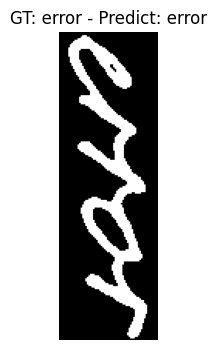

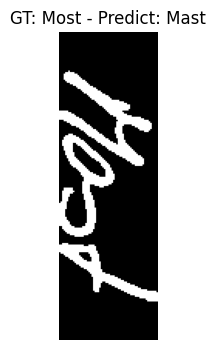

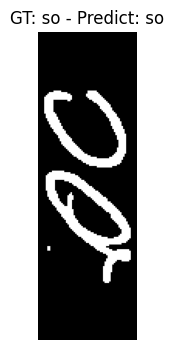

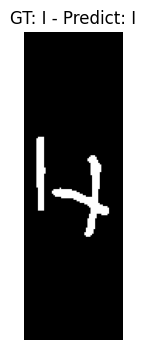

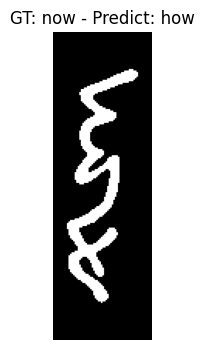

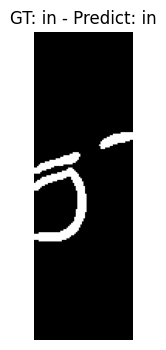

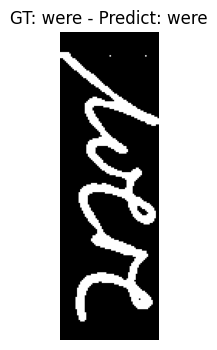

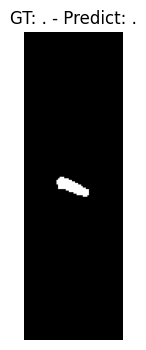

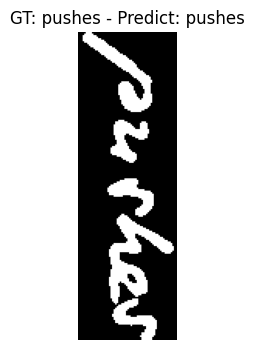

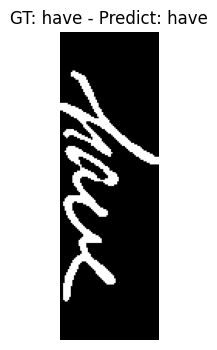

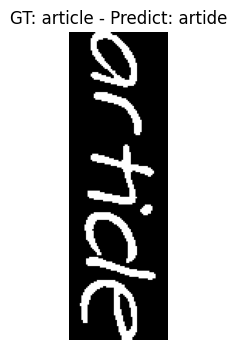

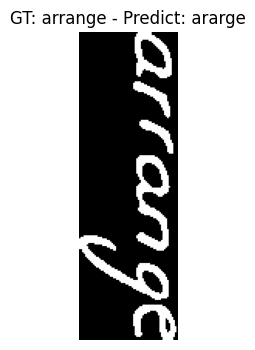

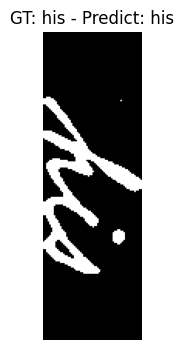

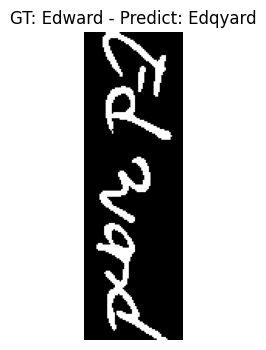

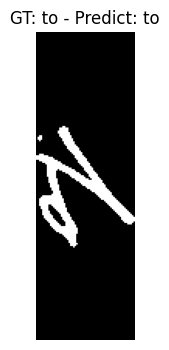

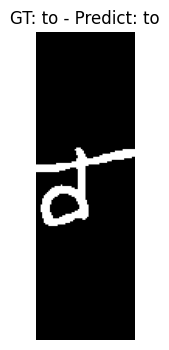

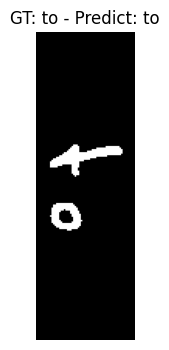

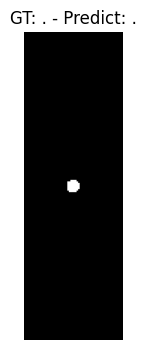

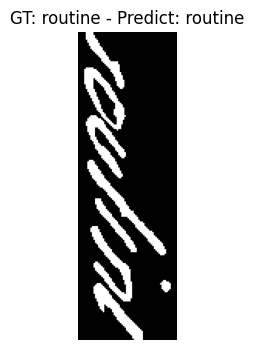

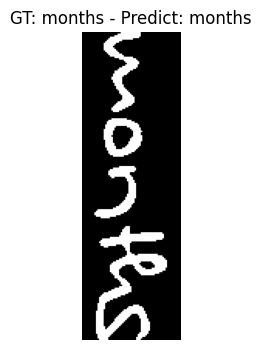

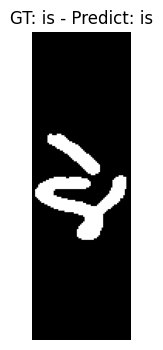

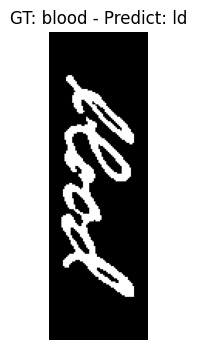

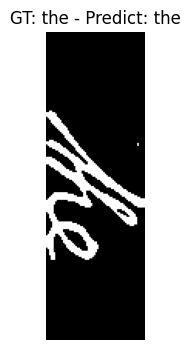

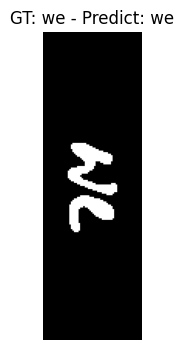

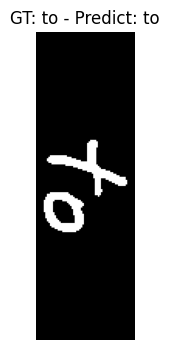

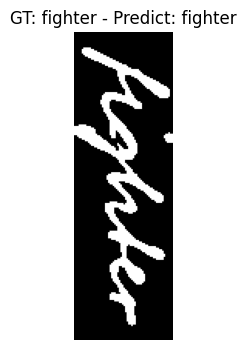

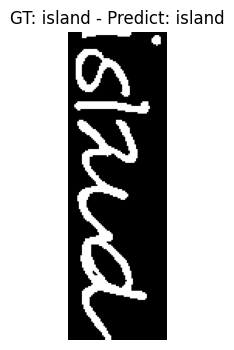

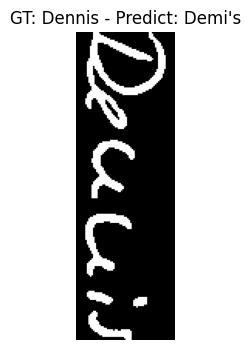

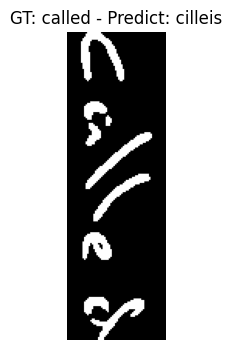

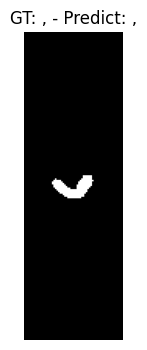

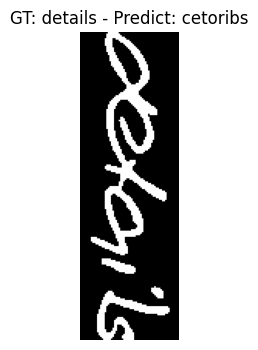

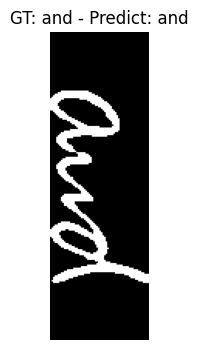

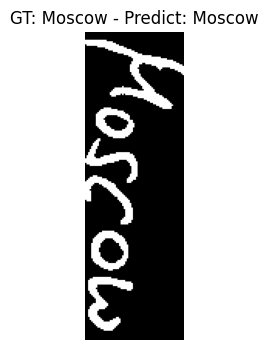

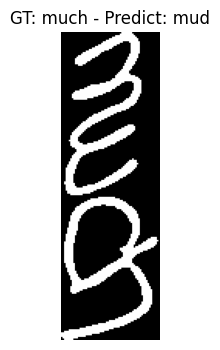

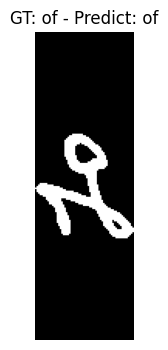

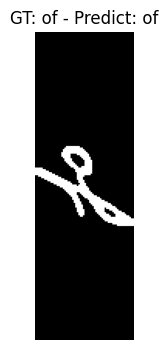

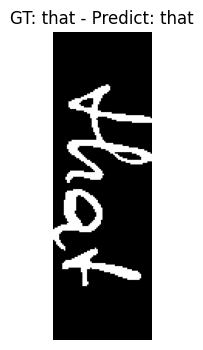

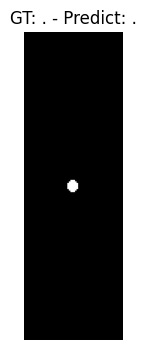

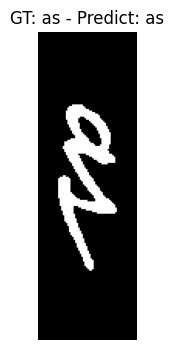

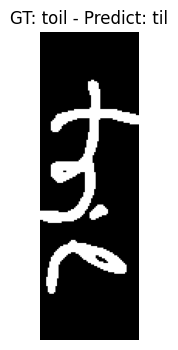

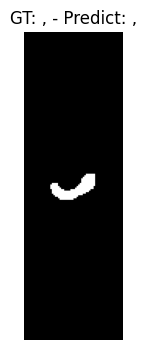

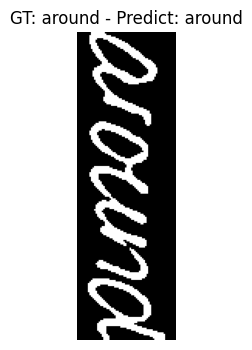

KeyboardInterrupt: 

In [ ]:
# Получение предсказаний модели
predicts = model.predict(test_X)
labels = decode_predictions(predicts)

# Последовательный вывод изображений
for idx in range(len(test_X)):
    plt.figure(figsize=(4, 4))
    plt.imshow(test_X[idx].astype(np.uint8), cmap='gray')

    predicted_char = labels[idx]
    gt_label = decode_label(test_y[idx], alphabet)

    plt.title(f'GT: {gt_label} - Predict: {predicted_char}')
    plt.axis("off")
    plt.show()